# Time Series Forecasting - AR, MA, ARIMA,SARIMAX

AR and MA are Stochastic Methods! [Random Probability Distribution]
ARIMA [Gaussian Distribution]

Autoregressive Integrated Moving Averages.
The general process for ARIMA models is the following:

* Visualize the Time Series Data
* Identify if the model is multiplicative or additive
* Identify time series components: Trend, Cycle, Seasonality, Residuals
* Make the time series data stationary
  * Rolling Statistics
  * ADCF Test (unit root test)
* Perform log transformation on data to make it linear and differencing to make it stationary
* Plot the Partial AutoCorrelation and AutoCorrelation Charts
* Construct the ARIMA Model or Seasonal ARIMA based on the data
* Do grid search and choose an optimal model based on AIC(low), BIC, HQIC
* Use the model to make predictions

Performance matrix
* Check if model residuals comply with OLS assumptions
* Forecast and calculate forecasting error: MAPE(low), MAE,RSS(low)

Let's go through these steps!

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
plt.style.use('ggplot')
import warnings 
warnings.filterwarnings("ignore") 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import r2_score

In [3]:
data = pd.read_csv('airline-passengers.csv',index_col ='Month',parse_dates = True) 
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
data.shape

(144, 1)

In [5]:
data.isnull().sum()

Passengers    0
dtype: int64

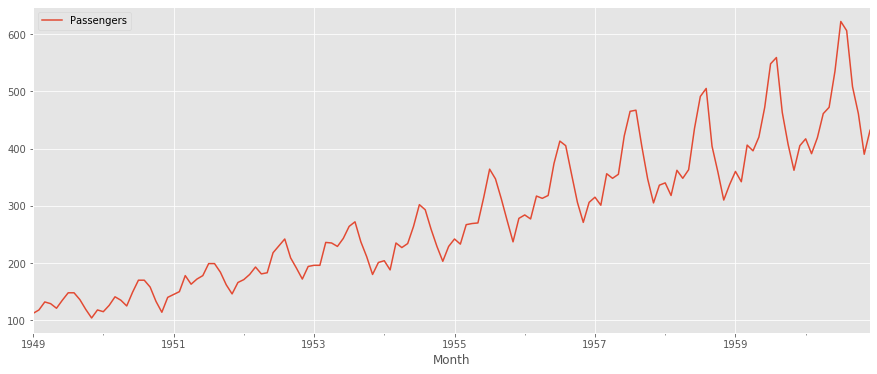

In [6]:
data.plot()

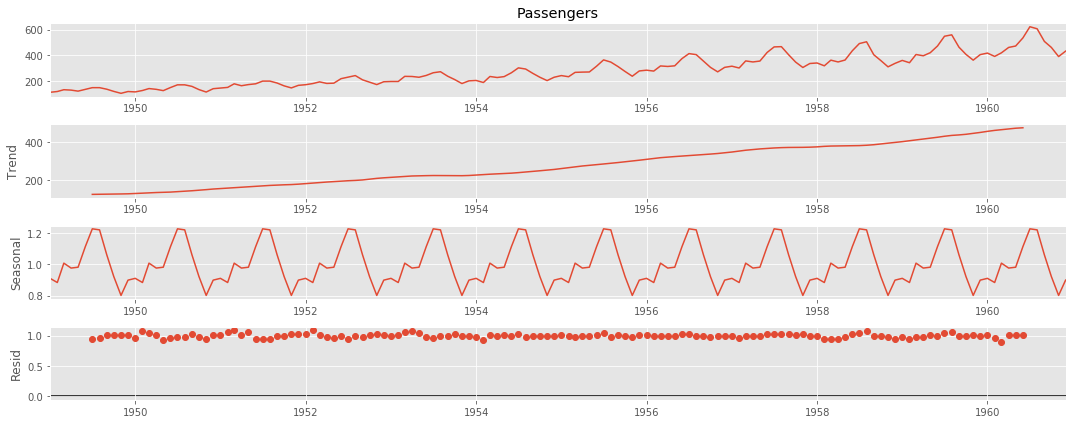

In [7]:
decomposed = seasonal_decompose(data['Passengers'], model='multiplicative')
x =decomposed.plot(); #See note below about this

In [8]:
def printStats(dataframe):
      print("Rows     :", dataframe.shape[0])
      print("Columns  :", dataframe.shape[1])
      print("\n Features \n", dataframe.columns.to_list())
      print("\n Missing Values \n", dataframe.isnull().any())
      print("\n Unique Values \n", dataframe.nunique())
printStats(data)


Rows     : 144
Columns  : 1

 Features 
 ['Passengers']

 Missing Values 
 Passengers    False
dtype: bool

 Unique Values 
 Passengers    118
dtype: int64


In [9]:


from statsmodels.tsa.stattools import adfuller
test_result=adfuller(data)

def adfuller_test(X):
    result=adfuller(X)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.0500:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [10]:
adfuller_test(data)


ADF Test Statistic : 0.8153688792060456
p-value : 0.991880243437641
#Lags Used : 13
Number of Observations Used : 130
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [11]:
# perform Dickey-Fuller test
#Ho: It is non stationary
#H1: It is stationary

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rollmean=timeseries.rolling(window=12).mean()
    rollstd=timeseries.rolling(window=12).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rollmean, color='red', label='Rolling Mean')
    plt.plot(rollstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

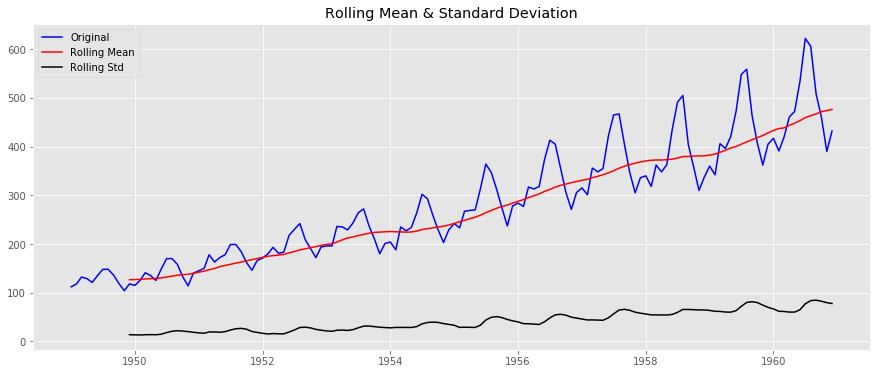

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [12]:
test_stationarity(data["Passengers"])

This is not stationary because :
 *  mean is increasing even though the std is small.
 *  Test stat is > critical value.

## Make Stationary

Smoothing Technique to remove Stationarity:
    * Moving average 
    * Exponentially weighted moving average.

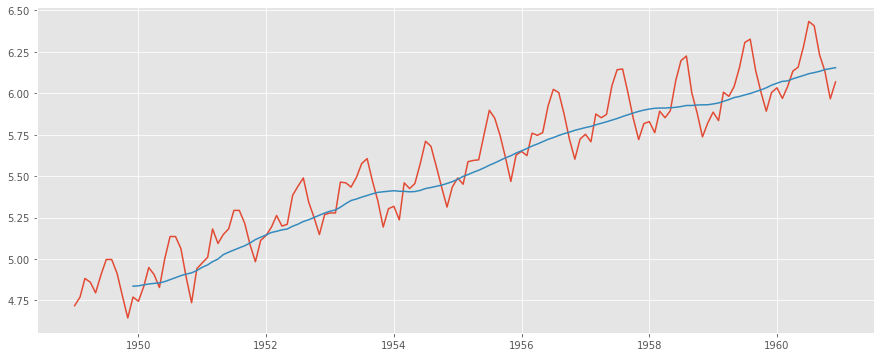

In [13]:
# Moving average to know the trend of the mean
data_log_trans=np.log(data)
movingAvg=data_log_trans.rolling(window=12).mean()
movingstd=data_log_trans.rolling(window=12).std()
plt.plot(data_log_trans)
plt.plot(movingAvg)

Now, subtract rolling mean (movingAvg) and log_transformed data

In [14]:
log_trans_rollmean_diff=data_log_trans-movingAvg
log_trans_rollmean_diff.dropna(inplace=True)  # we take the average of first 12 so 11 values are null

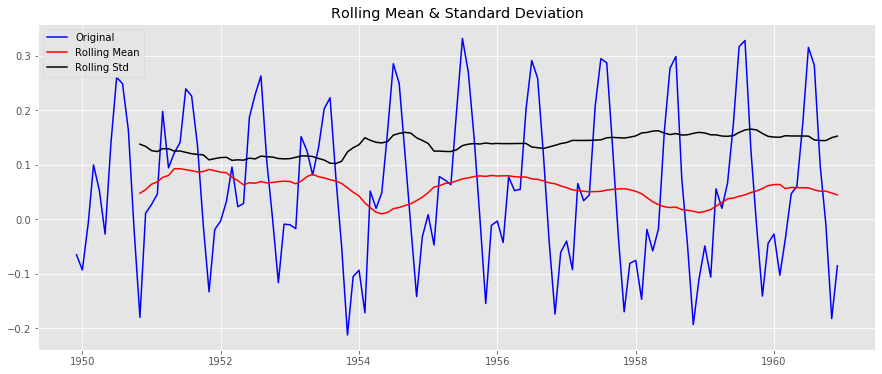

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [15]:
test_stationarity(log_trans_rollmean_diff)

Inference :
    * The rolling values are varying slightly but there is no specific trend.
    * The test statistics is smaller than the 5 % critical values. That tells us that we are 95% confident that this series is stationary.

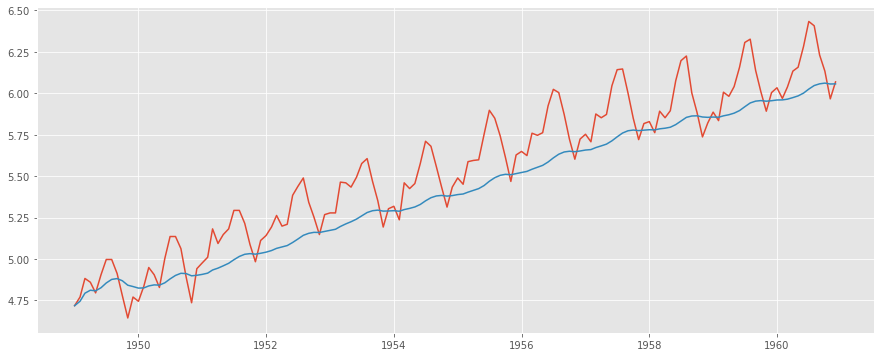

In [16]:
# check wheather the mean and std are stationary w.r.t exponential weighted average

exponentialDecayWeightedAvg=data_log_trans.ewm(halflife=12,min_periods=0,adjust=True).mean()
plt.plot(data_log_trans)
plt.plot(exponentialDecayWeightedAvg)

# not stationary

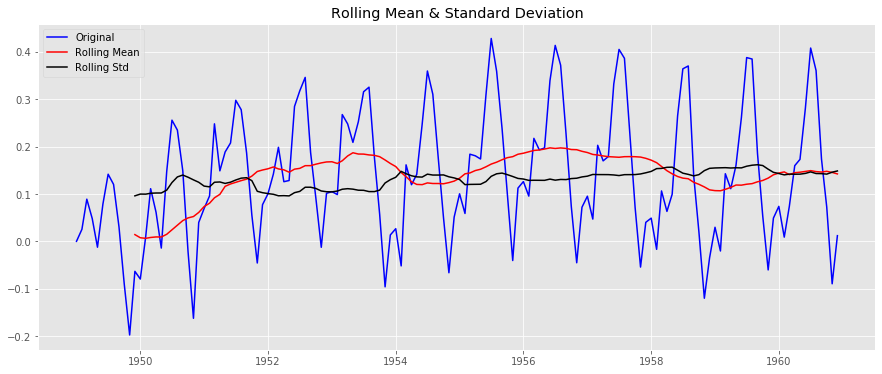

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [17]:
# convert weighted Average to stationary
data_logscaleMinusExpWeigthAvg=data_log_trans-exponentialDecayWeightedAvg
test_stationarity(data_logscaleMinusExpWeigthAvg)

It is stationary because:
  * Rolling values have less variations in mean and standard deviation in magnitude.
  * the test statistic is smaller than 1% of the critical value. So we can say we are almost 99% confident that this is stationary.

## Seasonality Analysis


Previously we saw just trend part of the time series, now we will see both trend and seasonality.There are two common methods to remove trend and seasonality, they are:
*  Differencing: by taking difference using time lag
*  Decomposition: model both trend and seasonality, then remove them

=> Here we perform Differencing

In [18]:
# KPSS test is performed to know how many differencing should be done to remove non stationarity

import pmdarima as pm 

pm.arima.ndiffs(data_log_trans,alpha=0.05,test='kpss',max_d=4)

1

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
def plot_data_properties(data, ts_plot_name="Time Series plot"):
    '''
    Summary:
    -------
    Plots various plots, including time series, autocorrelation,
    partial autocorrelation and distribution plots of data.
    
    Parameters:
    ----------
    ts_plot_name(String): The name of the time series plot
    data(pd.Dataframe, pd.Series, array): Time Series Data
    
    Returns:
    --------
    None
    
    '''
    plt.figure(figsize=(16,4))
    plt.plot(data)
    plt.title(ts_plot_name)
    plt.ylabel('Passengers')
    plt.xlabel('Year')
    fig, axes = plt.subplots(1,3,squeeze=False)
    fig.set_size_inches(16,4)
    plot_acf(data, ax=axes[0,0], lags=48);
    plot_pacf(data, ax=axes[0,1], lags=48);
    sns.distplot(data, ax=axes[0,2])
    axes[0,2].set_title("Probability Distribution")

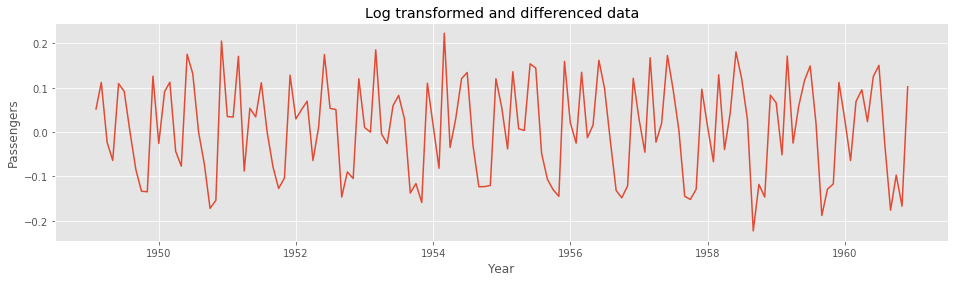

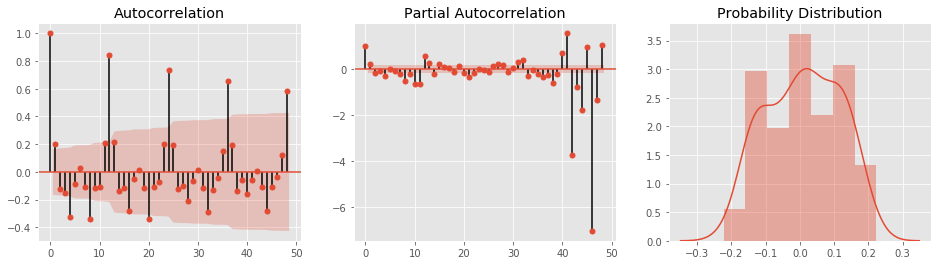

In [20]:
# Making trend Stationary

log_data_diff = data_log_trans.diff(1)[1:].dropna()
plot_data_properties(log_data_diff, 'Log transformed and differenced data')

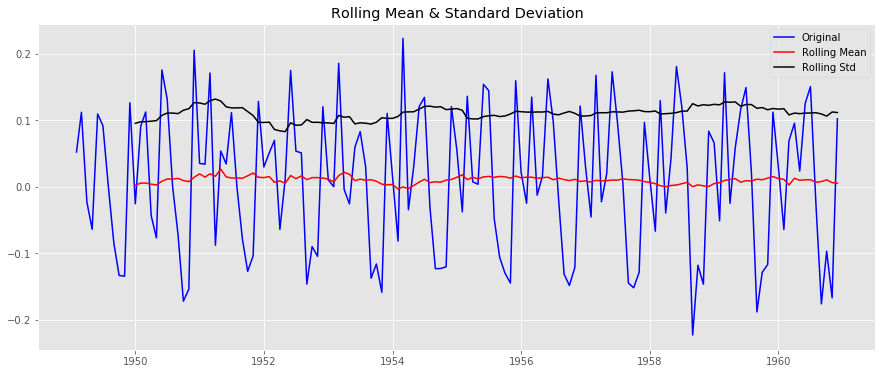

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [21]:
test_stationarity(log_data_diff)

It is stationary because:
* the mean and std variations have small variations with time.
*  test statistic is less than 10% of the critical values, so we can be 90 % confident that this is stationary.

Decomposing:
* Here we model both the trend and the seasonality, then the remaining part of the time series is returned

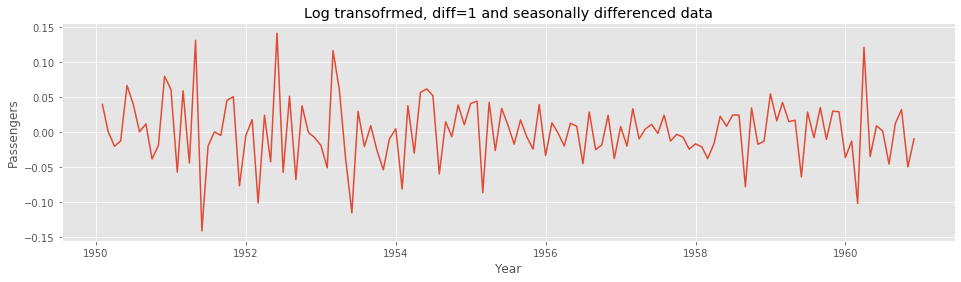

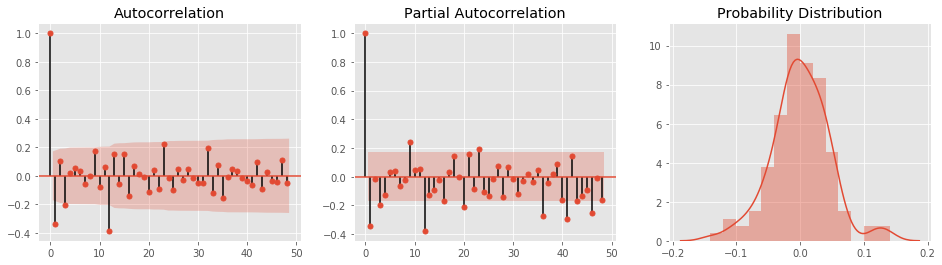

In [22]:
# Making Seasonal Stationary

seasonally_diffed_data = log_data_diff.diff(12)[12:]
plot_data_properties(seasonally_diffed_data, 'Log transofrmed, diff=1 and seasonally differenced data')


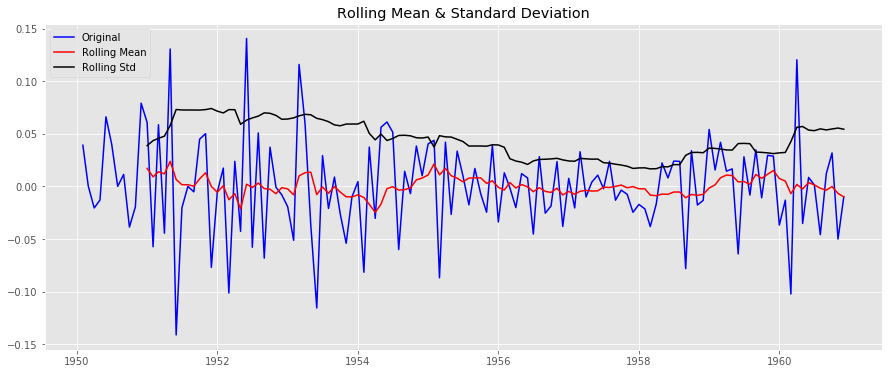

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [23]:
test_stationarity(seasonally_diffed_data)

This is stationary because:
*  test statistic is lower than 1% critical values.
*  the mean and std variations have small variations with time

* Identification of an AR model is often best done with the PACF.
* For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
* Identification of an MA model is often best done with the ACF rather than the PACF.

For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

p,d,q 
* p AR model lags 
* d differencing 
* q MA lags

# Model Fitting

# 1. Auto Regressive (AR)

plotting AR model


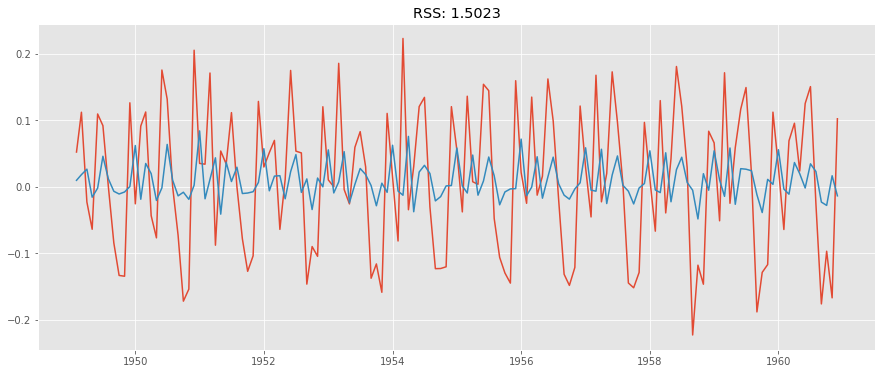

In [24]:
from statsmodels.tsa.arima_model import ARIMA

model=ARIMA(data_log_trans,order=(2,1,0))  # seasonality not included in ARIMA
model_fit=model.fit()
plt.plot(log_data_diff)
plt.plot(model_fit.fittedvalues)
diff=((model_fit.fittedvalues-log_data_diff['Passengers'])**2).dropna()
RSS_AR=sum(diff)

plt.title('RSS: %.4f' % RSS_AR)
print('plotting AR model')

# 2. MOVING AVERAGE (MA)

plotting MA model


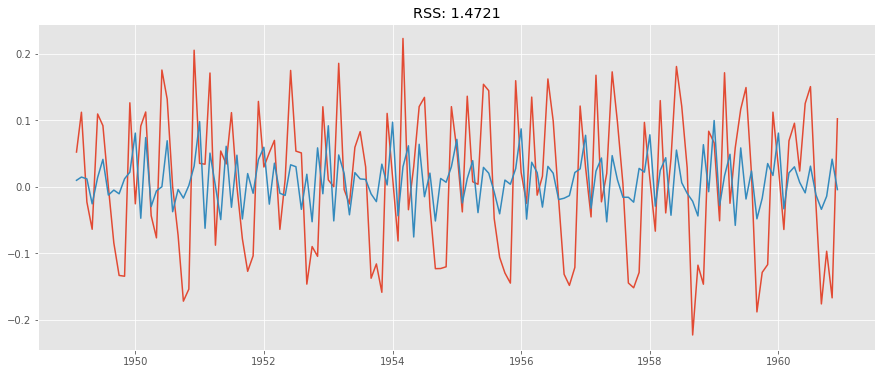

In [25]:
# p =0,q=2,d=1
model=ARIMA(data_log_trans,order=(0,1,2))
model_fit=model.fit()
plt.plot(log_data_diff)
plt.plot(model_fit.fittedvalues)
diff=((model_fit.fittedvalues-log_data_diff['Passengers'])**2).dropna()
RSS_MA=sum(diff)
plt.title('RSS: %.4f' % RSS_MA)
print('plotting MA model')

# 3. ARIMA

Text(0.5, 1.0, 'RSS: 1.0292 ')
plotting ARIMA model


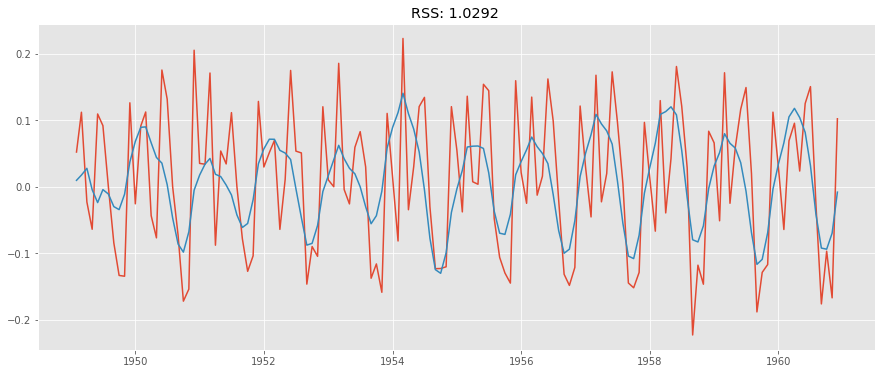

In [26]:
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

# Seasonal component should be removed to use ARIMA..doesnot support seasonal but only cyclic

model=ARIMA(data_log_trans,order=(2,1,2))
results_ARIMA=model.fit()
plt.plot(log_data_diff)
plt.plot(results_ARIMA.fittedvalues)
diff=((results_ARIMA.fittedvalues-log_data_diff['Passengers'])**2).dropna()
RSS_ARIMA=sum(diff)
# residual sum of square


print(plt.title('RSS: %.4f ' % RSS_ARIMA  ))

print('plotting ARIMA model')


In [114]:
def best_sarima_model(train_data,p,q,P,Q,d=1,D=1,s=12):
    best_model_aic = np.Inf 
    best_model_bic = np.Inf 
    best_model_hqic = np.Inf
    best_model_order = (0,0,0)
    models = []
    for p_ in p:
        for q_ in q:
            for P_ in P:
                for Q_ in Q:
                    try:
                        no_of_lower_metrics = 0
                        model = SARIMAX(endog=train_data,order=(p_,d,q_), seasonal_order=(P_,D,Q_,s),
                                        enforce_invertibility=False).fit()
                        models.append(model)
                        if model.aic <= best_model_aic: no_of_lower_metrics+=1
                        if model.bic <= best_model_bic: no_of_lower_metrics+=1
                        if model.hqic <= best_model_hqic:no_of_lower_metrics+=1
                        if no_of_lower_metrics >= 2:
                            best_model_aic = np.round(model.aic,0)
                            best_model_bic = np.round(model.bic,0)
                            best_model_hqic = np.round(model.hqic,0)
                            best_model_order = (p_,d,q_,P_,D,Q_,s)
                            current_best_model = model
                            models.append(model)
                            print("Best model so far: SARIMA" +  str(best_model_order) + 
                                  " AIC:{} BIC:{} HQIC:{}".format(best_model_aic,best_model_bic,best_model_hqic)+
                                  " resid:{}".format(np.round(np.exp(current_best_model.resid).mean(),3)))

                    except:
                        pass

    print('\n')
    print(current_best_model.summary())                
    return current_best_model, models

In [115]:
best_model, models = best_sarima_model(train_data=data_log_trans,p=range(3),q=range(3),P=range(3),Q=range(3))


Best model so far: SARIMA(0, 1, 0, 0, 1, 0, 12) AIC:-435.0 BIC:-432.0 HQIC:-434.0 resid:1.766
Best model so far: SARIMA(0, 1, 0, 0, 1, 1, 12) AIC:-468.0 BIC:-462.0 HQIC:-465.0 resid:1.767
Best model so far: SARIMA(0, 1, 1, 0, 1, 1, 12) AIC:-483.0 BIC:-475.0 HQIC:-480.0 resid:1.767


                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.696
Date:                            Tue, 29 Dec 2020   AIC                           -483.393
Time:                                    16:20:19   BIC                           -474.767
Sample:                                01-01-1949   HQIC                          -479.888
                                     - 12-01-1960                                         
Covariance Type:                              opg                              

# 4. SARIMAX

In [28]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [92]:

SARIMAX_model = SARIMAX(endog=data_log_trans,order=(0,1,1), seasonal_order=(0,1,1,12),
                                        enforce_invertibility=False).fit()
SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.696
Date:                            Tue, 29 Dec 2020   AIC                           -483.393
Time:                                    16:12:38   BIC                           -474.767
Sample:                                01-01-1949   HQIC                          -479.888
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4005      0.073     -5.486      0.000      -0.544      -0.257
ma.S.L12      -0.5575      0.096     -5.793      0.000      -0.746      -0.369
sigma2         0.0013      0.000      9.123      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                       37.40   Jarque-Bera (JB):                 1.89
Prob(Q):                              0.59   Prob(JB):                         0.39
Heteroskedasticity (H):               0.58   Skew:                             0.02
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0, 0.5, 'Residuals')

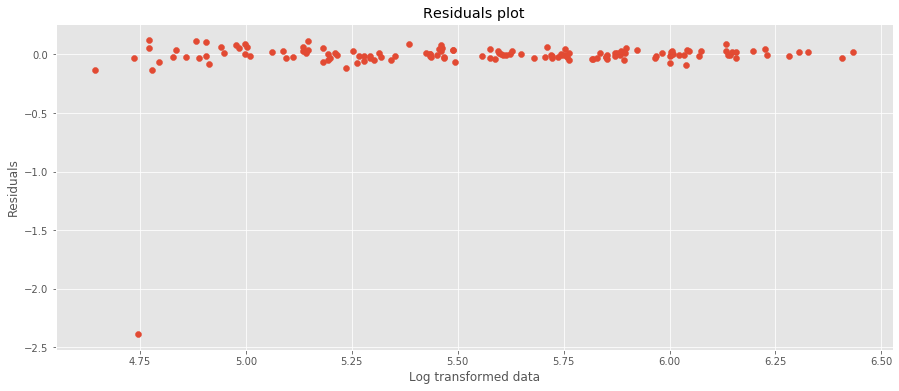

In [93]:
plt.scatter(x=data_log_trans[1:], y=SARIMAX_model.resid[1:]);
plt.title('Residuals plot')
plt.xlabel('Log transformed data')
plt.ylabel('Residuals')

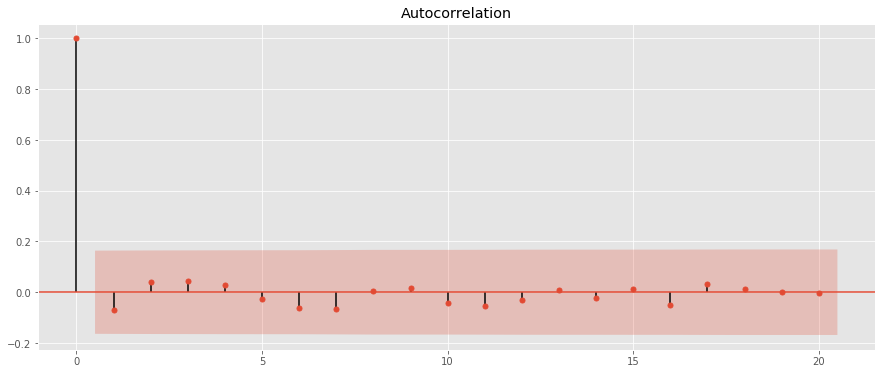

In [94]:
plot_acf(SARIMAX_model.resid[1:], lags=20);


Now, it is turn to predict home sales from 2018-01-01 to 2019-01-01. I will use MAPE - mean absolute percentage error to see how well the model performs. Best model we have got is SARIMA(order=(0,1,2),seasonal_order=(0,1,1,12). I prefer MAPE error in time series analysis as it is more intuitive. Sklearn doesn't provide MAPE metric, that's why we have to code it ourselves.

In [95]:
def mean_abs_pct_error(actual_values, forecast_values):
    err=0
    for i in range(len(forecast_values)):
        err += np.abs(actual_values.values[i] - forecast_values.values[i])/actual_values.values[i]
    return err[0] * 100/len(forecast_values)

In [96]:
def mean_abs_error(actual_values, forecast):
    err=0
    for i in range(len(forecast)):
        err += np.abs(actual_values.values[i] - forecast.values[i])
    return err[0] /len(forecast)

When you use predict function, there are some nuances to be careful about predict() function parameters:

type = 'levels' means to predicted values will be at the same level with endog/training values, in our case they were log transformed and not diffed at all. Then, if you notice I have np.exp() to scale the predicted values to original data. Remember, np.exp(np.log(a)) = a. So, np.exp(np.log(original data)) = original data
dynamice = True means to use the predicted value for time = t as a predictor for time = t+1.

In [97]:
test_start_date = '1959-01-01'
training_data = data[:test_start_date]
test_data = data[test_start_date:]

In [117]:
preds_best=np.exp(SARIMAX_model.predict(start=test_start_date,end='1960-12-01', dynamic=True, typ='levels'))
print("MAPE:{}%".format(np.round(mean_abs_pct_error(test_data,preds_best),2)))
print("MAE:{}".format(np.round(mean_absolute_error(test_data,preds_best),2)))

MAPE:8.0%
MAE:37.09


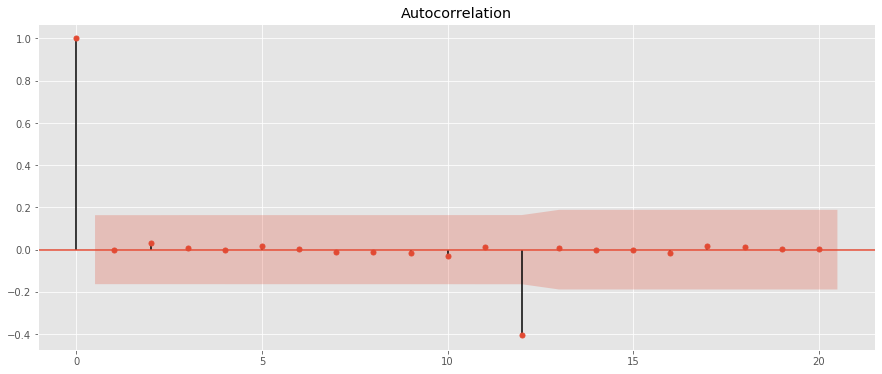

In [99]:
plot_acf(SARIMAX_model.resid, lags=20);


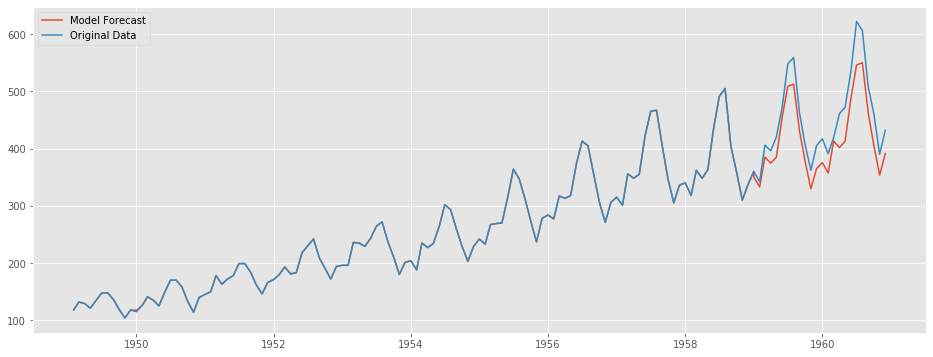

In [100]:
model_data = training_data.values[1:].reshape(120) - SARIMAX_model.resid[1:121]
model_data = pd.concat((model_data,preds_best))
plt.figure(figsize=(16,6));
plt.plot(model_data);
plt.plot(data[1:]);
plt.legend(['Model Forecast','Original Data']);

In [101]:
training_data.values[1:].shape

(120, 1)

In [102]:
SARIMAX_model.resid[1:].shape

(143,)

## Select Best SARIMAX parameters

In [118]:
tests_score = []
trains_score = []

models_order = []
models_aic = []
for model in models:
    if model.aic <-400:
        #model_order = (model.model_orders['ar'], model.model_orders['ma'],model.model_orders['seasonal_ar'],model.model_orders['seasonal_ma']/12)
        model_order = "ar:" + str(model.model_orders['ar']) + " ma:" + str(model.model_orders['ma']) + " s_ar:" + str(int(model.model_orders['seasonal_ar']/12)) + " s_ma:" + str(int(model.model_orders['seasonal_ma']/12))
        models_order.append(model_order)
        models_aic.append(model.aic)
        train_forecasts = training_data.values[1:].reshape(120) - best_model.resid[1:121]
        train_mae = mean_absolute_error(training_data[1:], train_forecasts)
        trains_score.append(np.round(train_mae,3))
        preds=np.exp(model.predict(start=test_start_date, end='1960-12-01', dynamic=True, typ='levels'))    

        test_mape = mean_abs_pct_error(test_data,preds)
        tests_score.append(np.round(test_mape,3))
model_properties = {'aic':models_aic, 'model_order':models_order, 'train_score': trains_score, 'test_score':tests_score}

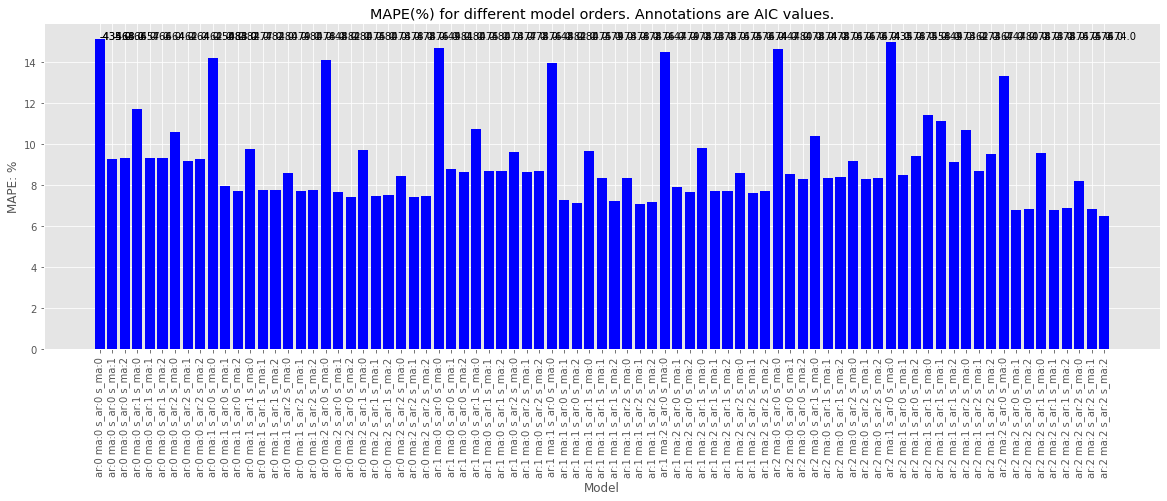

In [119]:
colors = ['g' if x < 6.05 else 'b' for x in model_properties['test_score']]
plt.figure(figsize=(20,6));
plt.bar(model_properties['model_order'],model_properties['test_score'], color= colors);
plt.xlabel('Model');
plt.ylabel('MAPE: %');
plt.title('MAPE(%) for different model orders. Annotations are AIC values.')
for i,aic in enumerate(model_properties['aic']):
    plt.annotate(np.round(aic,0), (model_properties['model_order'][i], model_properties['test_score'][1]));
plt.xticks(rotation=90);



In [120]:
SARIMAX_best_model = SARIMAX(endog=data_log_trans,order=(2,1,2), seasonal_order=(2,1,2,12),
                                        enforce_invertibility=False).fit()
SARIMAX_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                 245.916
Date:                            Tue, 29 Dec 2020   AIC                           -473.831
Time:                                    16:21:51   BIC                           -447.955
Sample:                                01-01-1949   HQIC                          -463.316
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1401      0.940      0.149      0.882      -1.702       1.982
ar.L2          0.2421      0.297      0.815      0.415      -0.340       0.824
ma.L1         -0.5421      0.970     -0.559      0.576      -2.443       1.359
ma.L2         -0.1749      0.620     -0.282      0.778      -1.390       1.041
ar.S.L12      -0.2684     21.675     -0.012      0.990     -42.751      42.215
ar.S.L24      -0.0046      1.596     -0.003      0.998      -3.133       3.123
ma.S.L12      -0.3248     21.682     -0.015      0.988     -42.821      42.172
ma.S.L24      -0.1119     11.306     -0.010      0.992     -22.271      22.047
sigma2         0.0013      0.000      8.063      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                       39.04   Jarque-Bera (JB):                 4.39
Prob(Q):                              0.51   Prob(JB):                         0.11
Heteroskedasticity (H):               0.61   Skew:                            -0.03
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [121]:
SARIMAX_model_pred = np.exp(SARIMAX_best_model.predict(start=test_start_date,end='1960-12-01', dynamic=True, typ='levels'))
print("MAPE:{}%".format(np.round(mean_abs_pct_error(test_data,SARIMAX_model_pred),2)))
print("MAE:{}".format(np.round(mean_absolute_error(test_data,SARIMAX_model_pred),2)))

MAPE:6.51%
MAE:30.2


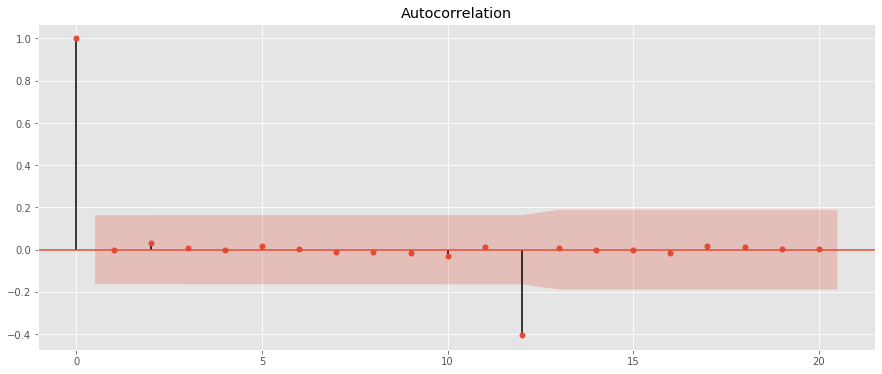

In [123]:
plot_acf(SARIMAX_best_model.resid, lags=20);


## Check for Normality Assumption of OLS

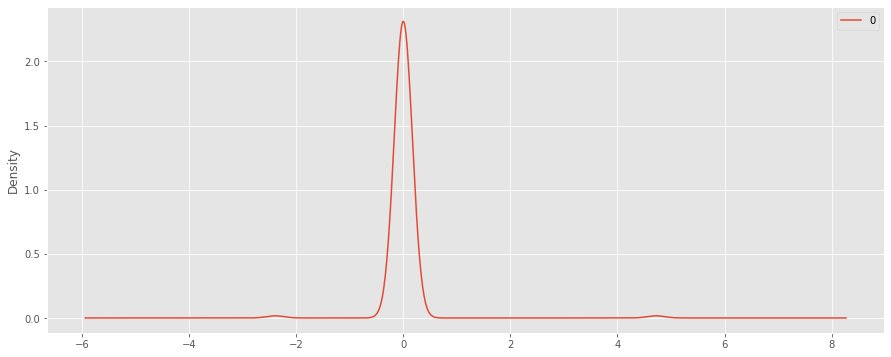

                0
count  144.000000
mean     0.017527
std      0.443990
min     -2.385002
25%     -0.023739
50%     -0.000781
75%      0.026282
max      4.718499


In [124]:
from pandas import DataFrame
residuals_SARIMA = DataFrame(SARIMAX_best_model.resid)
residuals_SARIMA.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals_SARIMA.describe())

Conclusion : Residuals has zero mean.i,e.
            * Residuals have constant variance
            * Residuals are normally distributed


## Forecast : Next 2 Months Passengers

In [165]:
from pandas import DataFrame
from pandas.tseries.offsets import DateOffset
future_dates=[data.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=data.columns)


In [166]:
future_df=pd.concat([data,future_datest_df])


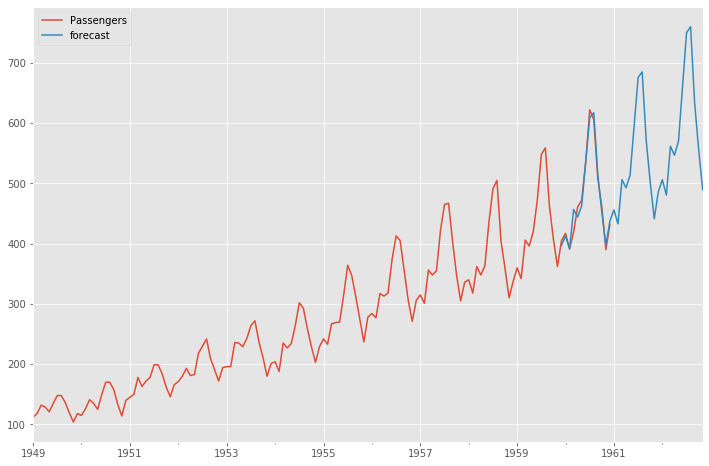

In [167]:
future_df['forecast'] = np.exp(SARIMAX_best_model.predict(start ='1959-12-01',end='1962-11-01', dynamic= True))
future_df[['Passengers', 'forecast']].plot(figsize=(12, 8))

In [169]:
Results=pd.concat([future_df['Passengers'],future_df['forecast']],axis=1)
Results.rename(columns={'forecast' :'Predictions_SARIMA'},inplace=True)
Results.tail(40)

,Passengers,Predictions_SARIMA
1959-08-01,559,NaN
1959-09-01,463,NaN
1959-10-01,407,NaN
1959-11-01,362,NaN
1959-12-01,405,397.174697
1960-01-01,417,412.689369
1960-02-01,391,391.264818
1960-03-01,419,456.738393
1960-04-01,461,444.317054
1960-05-01,472,462.593336
